In [24]:
import os.path as osp
import sys
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
this_dir = osp.abspath('./')
lib_path = osp.join(this_dir,'lib')
add_path(lib_path)
from datasets.multi_res_dataset.datasets.dataset_factory import get_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import random
import time
from tqdm import tqdm
get_dataset=get_dataset('pascal','ctdet')

In [25]:
class Opts():
    data_dir='/home/lishiqi/obj/CenterNet/src/lib/../../data'
    keep_res=False
    input_h=512
    input_w=512
    down_ratio=4
    mse_loss=False
    dense_wh=False
    cat_spec_wh=False
    reg_offset=True
    debug=0
    draw_ma_gaussian=False
    not_rand_crop=True
    scale=0
    shift=0
    flip=0
    no_color_aug=True

In [26]:
opt=Opts()
dataset_pascal=get_dataset(opt,'train')
objs=torch.load('../models/objs_2')

==> initializing pascal trainval0712 data.
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Loaded train 16551 samples


In [74]:
class PascalDataset(Dataset):
    def __init__(self,dataset,obj_res,pic_res,objs):
        self.objs=objs['objs_'+str(obj_res)]['pics_'+str(pic_res)]
        self.dataset=dataset
        self.obj_res=obj_res
        self.pic_res=pic_res
        self.avgpool=torch.nn.MaxPool2d(4,4)
        self.maxpool=torch.nn.MaxPool2d(4,4)
        self.max_objs=50
    def __len__(self):
        return len(self.objs)
    def __getitem__(self, index):
        dataset=self.dataset
        objs=self.objs
        pic_index=objs[index]['pic_index']
        obj_index=objs[index]['obj_index']
        obj_pic=dataset[pic_index]
        
        wh=obj_pic['wh'][obj_index]
        ori_pic=obj_pic['input']
        bbox=(obj_pic['bboxs'][obj_index]).astype(np.int)
        hms=obj_pic['hm']
        bbox_crop=self.crop_pic(ori_pic,bbox,wh)
        batch_dict=self.gen_offset(obj_pic['bboxs'],bbox_crop)
        crop_pic=ori_pic[:,bbox_crop[1]:bbox_crop[3],bbox_crop[0]:bbox_crop[2]]
        crop_hm=hms[:,bbox_crop[1]:bbox_crop[3],bbox_crop[0]:bbox_crop[2]]
        crop_resize_hm=self.avgpool(torch.Tensor(crop_hm))
        batch_dict['hm']=crop_resize_hm
        batch_dict['input']=crop_pic
        return batch_dict
    def gen_offset(self,obj_bboxes,bbox_crop):
        reg = np.zeros((self.max_objs, 2), dtype=np.float32)
        ind = np.zeros((self.max_objs), dtype=np.int64)
        reg_mask = np.zeros((self.max_objs), dtype=np.uint8)
        wh=np.zeros((self.max_objs,2),dtype=np.float32)
        
        bbox_output=bbox_crop/4
        w=bbox_output[2]-bbox_output[0]
        h=bbox_output[3]-bbox_output[1]

        for index,obj_bbox in enumerate(obj_bboxes):
            if (obj_bbox==0).all():
                print(type(obj_bbox))
                break
            if obj_bbox[0]>=bbox_crop[0] and obj_bbox[1]>=bbox_crop[1] and obj_bbox[2]<=bbox_crop[2] and obj_bbox[3]<=bbox_crop[3]:
                obj_bbox_offset=obj_bbox-[bbox_crop[0],bbox_crop[1],bbox_crop[0],bbox_crop[1]]
                ct = np.array([(obj_bbox_offset[0] + obj_bbox_offset[2]) / 2, (obj_bbox_offset[1] + obj_bbox_offset[3]) / 2], dtype=np.float32)
                ct=ct/4
                ct_int =ct.astype(np.int32)
                reg[index]=ct-ct_int
                index_ct=ct_int[1]*w+ct_int[0]
                wh[index]=[(obj_bbox_offset[2]-obj_bbox_offset[0])/4,(obj_bbox_offset[3]-obj_bbox_offset[1])/4]
                
                if index<=0 or index>=w*h:
                    reg_mask[index]=0
                    ind[index]=0
                else:
                    reg_mask[index]=1
                    ind[index]=index_ct
        if w==128:
            print(ind)
            print(reg_mask)
            input('s')
        wh_and_offset=dict(reg=reg,ind=ind,reg_mask=reg_mask,wh=wh)
        return wh_and_offset
                
    def crop_pic(self,pic,bbox,wh):
        bbox_crop=np.zeros(4,np.int)
        ori_w=pic.shape[2]
        ori_h=pic.shape[1]
        cut_w,cut_h=self.pic_res,self.pic_res
        if bbox[1]<ori_h-bbox[3]:
            max_h,h_l=bbox[1],True
            min_h=(cut_h+bbox[1])-ori_h
        else:
            max_h,h_l=(ori_h-bbox[3]),False
            min_h=cut_h-bbox[3]
        if bbox[0]<ori_w-bbox[2]:
            max_w,w_l=bbox[0],True
            min_w=(cut_w+bbox[0])-ori_w
        else:
            max_w,w_l=(ori_w-bbox[2]),False
            min_w=cut_w-bbox[2]
        max_h=min(max_h,cut_h-wh[1])
        max_w=min(max_w,cut_w-wh[0])
        min_h=max(0,min_h)
        min_w=max(0,min_w)
        
        rand_h=np.random.randint(min_h,max_h+1)
        rand_w=np.random.randint(min_w,max_w+1)

        if h_l:
            bbox_crop[1]=bbox[1]-rand_h
            bbox_crop[3]=bbox_crop[1]+cut_h
        else:
            bbox_crop[3]=bbox[3]+rand_h
            bbox_crop[1]=bbox_crop[3]-cut_h
        if w_l:
            bbox_crop[0]=bbox[0]-rand_w
            bbox_crop[2]=bbox_crop[0]+cut_w
        else:
            bbox_crop[2]=bbox[2]+rand_w
            bbox_crop[0]=bbox_crop[2]-cut_w

        return bbox_crop



In [75]:
class DatasetObj(Dataset):
    def __init__(self,dataset_obj,dataset,objs,obj_res,pic_res,loader_bses):
        dataloaders=[]
        dataloader_size=[]
        for res,loader_bs in zip(pic_res,loader_bses):
            dataloaders.append(iter(DataLoader(dataset_obj(dataset,obj_res,res,objs),batch_size=loader_bs,shuffle=True)))
            print('obj_res',obj_res,'pic_res',res,'bs',len(dataloaders[-1]))
        sum_len=0
        for dataloader in dataloaders: 
            sum_len+=len(dataloader)
            dataloader_size.append(len(dataloader))
        self.dataloaders=dataloaders
        self.dataloader_size=dataloader_size
        self.sum_len=sum_len
        self.random_pool=self.dataloader_size.copy()
    def __getitem__(self,index):
        indexs =[i for i in range(len(self.random_pool)) if self.random_pool[i]>0]
        loader_index=random.choice(indexs)
    
        self.random_pool[loader_index]-=1
        batch=self.dataloaders[loader_index].next()
        if index==self.sum_len-1:
            self.random_pool=self.dataloader_size.copy()
        return batch
    def __len__(self):
        return self.sum_len

In [76]:
class DatasetObjMuiltRes(Dataset):
    def __init__(self,objs,dataset,obj_res=[],pic_res=dict(),loader_bses=dict()):
        self.obj_res=obj_res
        dataloaders=[]
        def default_collate(batch):
            return batch[0]
        for res in obj_res:
            dataset_obj=DatasetObj(PascalDataset,dataset,objs,res,pic_res['pic_'+str(res)],loader_bses['pic_'+str(res)])
            dataloaders.append(iter(DataLoader(dataset_obj,num_workers=0,collate_fn=default_collate)))
        dataloader_size=[]
        sum_len=0
        for dataloader in dataloaders: 
            sum_len+=len(dataloader)
            dataloader_size.append(len(dataloader))
        self.dataloaders=dataloaders
        self.dataloader_size=dataloader_size
        self.sum_len=sum_len
        self.random_pool=self.dataloader_size.copy()
    def __getitem__(self,index):
        indexs =[i for i in range(len(self.random_pool)) if self.random_pool[i]>0]
        loader_index=random.choice(indexs)
        self.random_pool[loader_index]-=1
        batch=self.dataloaders[loader_index].next()
        if index==self.sum_len-1:
            self.random_pool=self.dataloader_size.copy()
        batch['res']=self.obj_res[loader_index]
        return batch
    def __len__(self):
        return self.sum_len

In [77]:
data=DatasetObjMuiltRes(objs,
                        dataset_pascal,
                   obj_res=[32,64,128,256],
                   pic_res=dict(pic_32=[64,128,192,256],
                                pic_64=[128,192,256,384],
                                pic_128=[256,384,512],
                                pic_256=[384,512]),
                   loader_bses=dict(pic_32=[128,48,16,8],
                                    pic_64=[128,64,32,16],
                                    pic_128=[64,32,8],
                                    pic_256=[32,16]))
def default_collate(batch):
    return batch[0]
loader=DataLoader(data,num_workers=10,collate_fn=default_collate)

obj_res 32 pic_res 64 bs 62
obj_res 32 pic_res 128 bs 60
obj_res 32 pic_res 192 bs 18
obj_res 32 pic_res 256 bs 10
obj_res 64 pic_res 128 bs 53
obj_res 64 pic_res 192 bs 33
obj_res 64 pic_res 256 bs 24
obj_res 64 pic_res 384 bs 19
obj_res 128 pic_res 256 bs 143
obj_res 128 pic_res 384 bs 73
obj_res 128 pic_res 512 bs 89
obj_res 256 pic_res 384 bs 273
obj_res 256 pic_res 512 bs 336


In [78]:
for batch in loader:
    if batch['input'].shape[2]!=512:
        continue
    print(batch['reg_mask'])
    input('s')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[    0  9881  9100 10408     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[    0  5822 10302 10656 10421 10061  9689     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]<class 'numpy.ndarray'

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

KeyboardInterrupt: 

In [ ]:
print(batch['wh'][0])
print(batch['ind'][0])
input('S')
wh=output['wh'][0]
print(wh)
wh=wh.view(2,-1)
print(wh[:,4137])
print(wh.shape)

In [10]:
from models.model import create_model
heads = {'hm': 20,'wh': 2,'reg': 2 }
model = create_model('resdcn_101',heads ,64)

In [11]:
state_dict=torch.load('/home/mayx/project/github/CenterNet/exp/ctdet/pascal_deeplab_multi_resnet101_512_change_lr/model_last.pth')

In [12]:
for k,v in state_dict.items():
    print(k)
print(state_dict['epoch'])

epoch
state_dict
optimizer
70


In [13]:
params=state_dict['state_dict']

In [14]:
model.cuda(0)

DeepLabV3PDect(
  (backbone): deeplabv3plus(
    (aspp): ASPP(
      (branch1): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
      (branch2): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
      (branch3): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
      (branch4): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(18, 18), dilation=(18, 18))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [15]:
model.load_state_dict(params)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

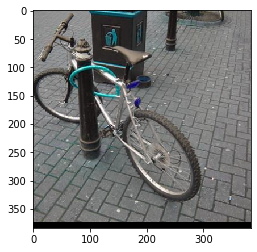

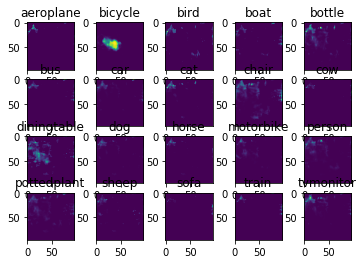

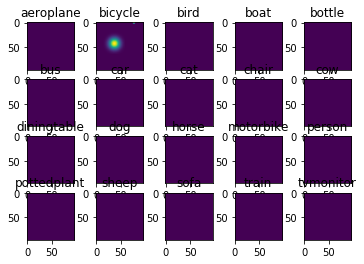

s


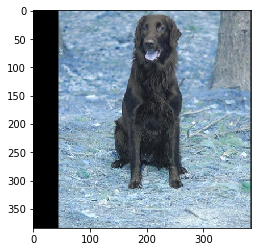

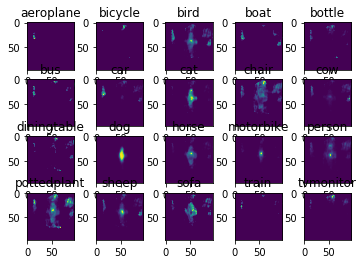

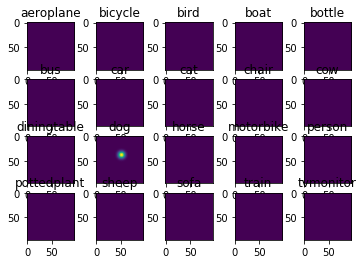

s


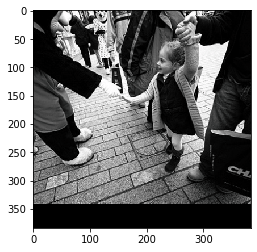

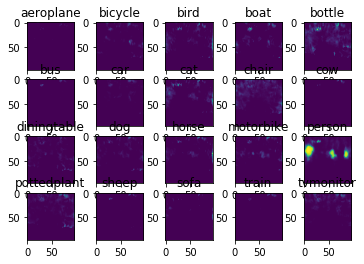

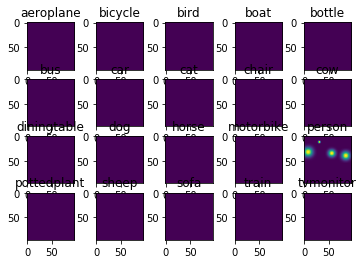

s


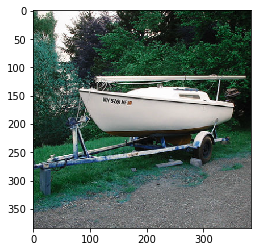

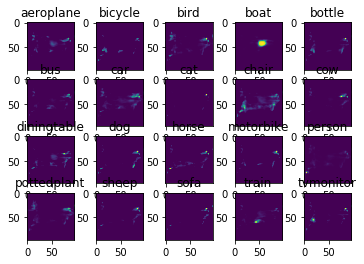

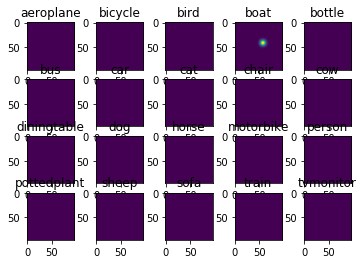

s


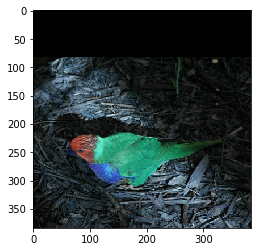

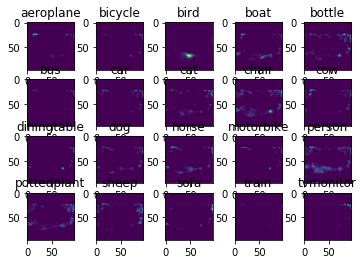

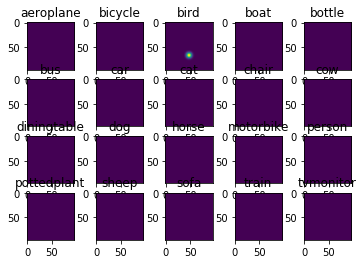

s


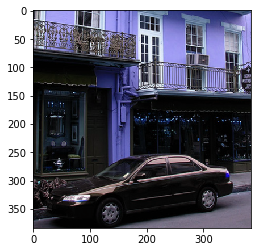

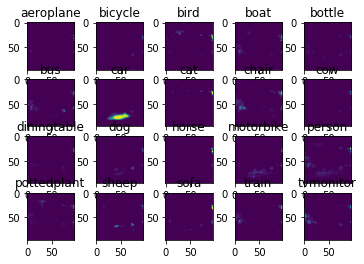

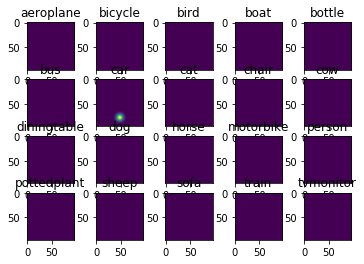

s


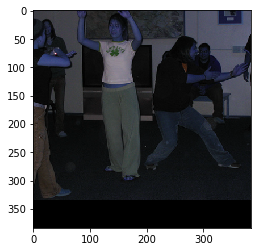

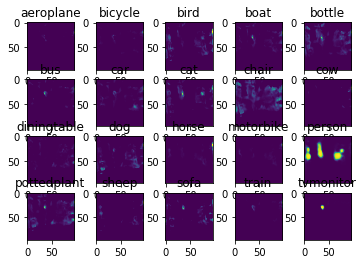

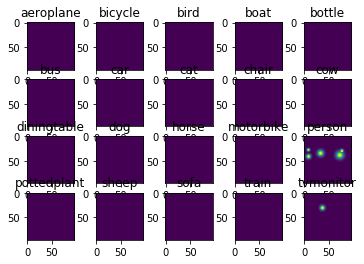

KeyboardInterrupt: 

In [16]:
from models.utils import _sigmoid
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
def draw_pic_hm(data,batch_output,batch_hm):
    classes=["aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
"horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
"train", "tvmonitor"]
    for pic,output,hm in zip(data,batch_output,batch_hm):
        plt.imshow(((pic.permute((1,2,0))*std+mean)*255).int())
        plt.show()
        for index,(out_hm) in enumerate(output):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(out_hm)
        plt.show()
        for index,(label_hm) in enumerate(hm):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(label_hm)
        plt.show()
model.eval()
for index,batch in enumerate(loader):
    data=batch['input'][:1]
    if data.shape[3]!=384:
        continue
    data=data.cuda(0)
    output,=model(data)
    draw_pic_hm(data.cpu().detach(),_sigmoid(output['hm'].cpu().detach()),batch['hm'][:1].cpu().detach())
#     print(output['wh'],output['wh'].shape)
#     print(output['reg'],output['reg'].shape)
#     print(batch['reg_mask'][:1],batch['reg_mask'][:1].shape)
    input('s')

In [19]:
print(batch['wh'][0])
print(batch['ind'][0])
input('S')
wh=output['wh'][0]
print(wh)
wh=wh.view(2,-1)
print(wh[:,4137])
print(wh.shape)

tensor([[31.7440, 34.3040],
        [ 0.0000,  0.0000],
        [19.2000, 80.3840],
        [12.0320, 52.9920],
        [46.3360, 59.9040],
        [17.6640, 36.3520],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0

In [29]:
wh[:,1250]

tensor([21.5040, 20.0936], device='cuda:0', grad_fn=<SelectBackward>)

In [61]:
wh=output['wh'][0]
print(wh.shape)

torch.Size([2, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


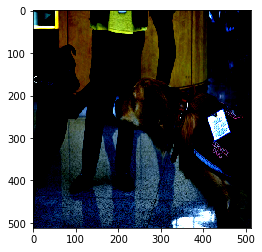

In [46]:
from PIL import Image
im = Image.open('../images/test8.jpg')
model.eval()
data=np.array(im)[:,:,:3]
mean=np.array([0.485, 0.456, 0.406],dtype=np.float32).reshape(1, 1, 3)
std=np.array([0.229, 0.224, 0.225],dtype=np.float32).reshape(1, 1, 3)
data=data/255
data=(data-mean)/std
plt.imshow(data)
plt.show()
data=np.transpose(data,(2,0,1))
data=torch.Tensor(data).unsqueeze(0)
data=data.cuda(0)
output=model(data)
hm=output[0]['hm']

In [47]:
output[0]['reg'][:,:,15,10]

tensor([[0.5587, 0.4294]], device='cuda:0', grad_fn=<SelectBackward>)

In [48]:
label_wh=batch['wh'][0]
print(label_wh.shape)

torch.Size([50, 2])


In [49]:
label_mask=batch['reg_mask'][0]
print(label_mask)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=torch.uint8)


In [51]:
label_wh[0]

tensor([86.7840, 30.2080])

In [25]:
output=model(data[:2])
hm=output[0]['hm']
plt.imshow(data.cpu()[0].permute(1,2,0))
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 11.91 GiB total capacity; 4.88 GiB already allocated; 60.38 MiB free; 15.84 MiB cached)

In [81]:
import torch
count=torch.load('./count.pth')


In [82]:
for k in count:
    print(k)

train: [1][0/538]|Tot: 0:00:09 |ETA: 0:00:00 |l 37.41 h 34.29 w 26.29 o 0.50 |l 37.41 h 34.29 w 26.29 o 0.50 | B:100 O64 P256 LR:1.250000e-04
train: [1][1/538]|Tot: 0:00:11 |ETA: 1:21:55 |l 27.30 h 24.87 w 19.45 o 0.49 |l 17.18 h 15.45 w 12.61 o 0.47 | B:100 O32 P128 LR:6.250000e-05
train: [1][2/538]|Tot: 0:00:16 |ETA: 0:50:06 |l 54.35 h 51.05 w 28.05 o 0.49 |l 162.55 h 155.81 w 62.47 o 0.49 | B:50 O256 P512 LR:5.000000e-04
train: [1][3/538]|Tot: 0:00:17 |ETA: 0:50:10 |l 47.00 h 43.81 w 27.07 o 0.49 |l 28.65 h 25.69 w 24.63 o 0.50 | B:100 O64 P256 LR:1.250000e-04
train: [1][4/538]|Tot: 0:00:18 |ETA: 0:40:22 |l 40.31 h 37.41 w 24.04 o 0.49 |l 16.88 h 15.04 w 13.42 o 0.50 | B:100 O64 P128 LR:1.250000e-04
train: [1][5/538]|Tot: 0:00:19 |ETA: 0:33:28 |l 47.93 h 44.81 w 26.27 o 0.49 |l 116.53 h 111.40 w 46.31 o 0.50 | B:50 O128 P512 LR:2.500000e-04
train: [1][6/538]|Tot: 0:00:20 |ETA: 0:29:43 |l 56.40 h 52.96 w 29.48 o 0.49 |l 141.11 h 134.46 w 61.63 o 0.48 | B:50 O256 P512 LR:5.000000e-04


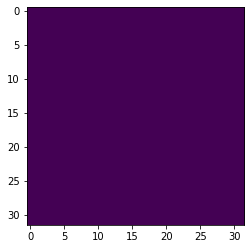

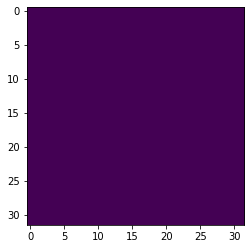

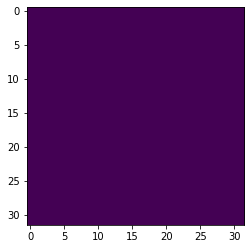

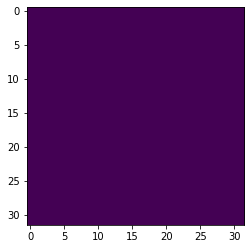

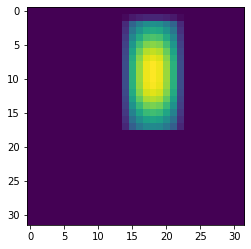

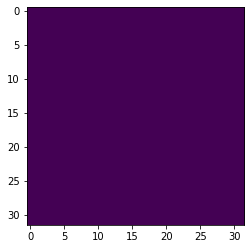

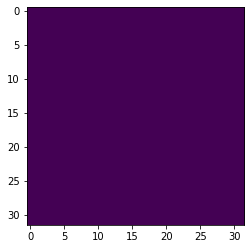

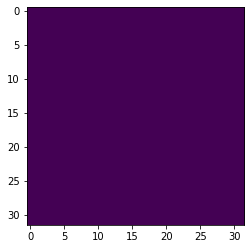

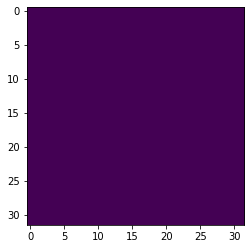

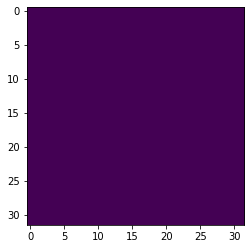

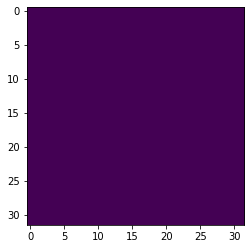

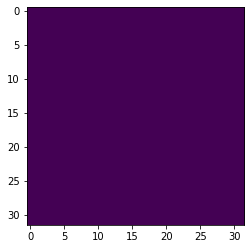

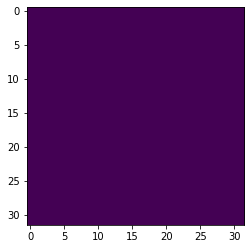

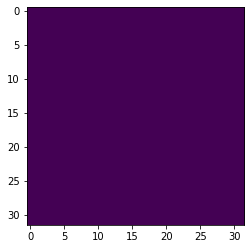

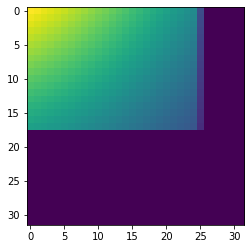

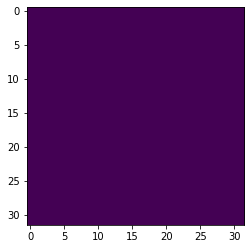

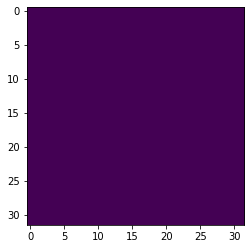

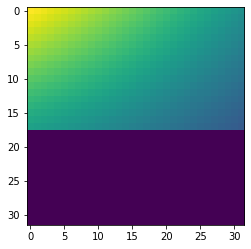

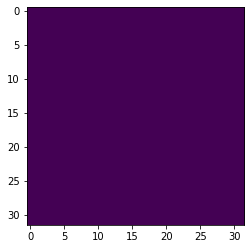

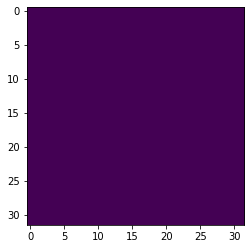

In [16]:
label_hm=batch['hm'][0]
for i in range(20):
    plt.imshow(label_hm[i])
    plt.show()

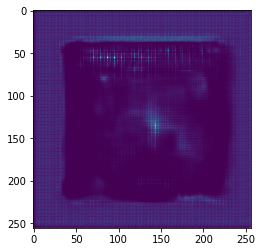

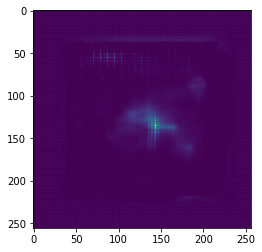

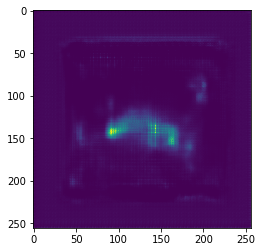

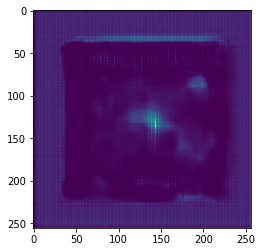

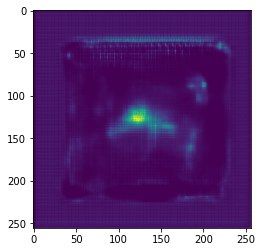

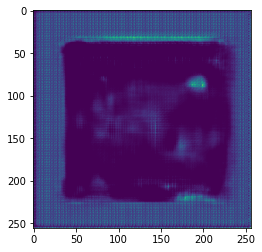

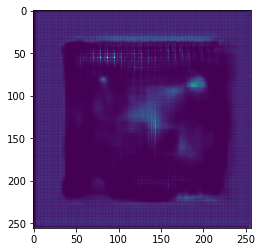

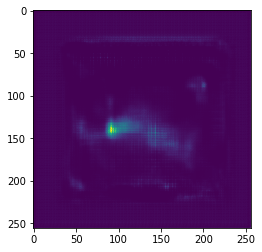

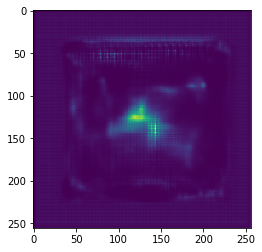

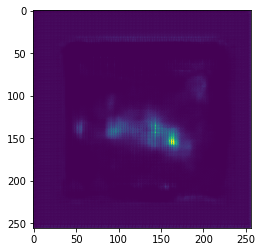

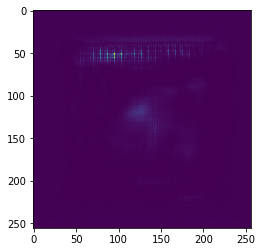

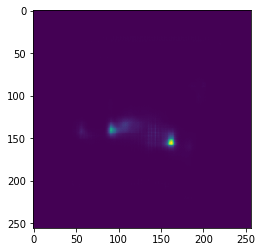

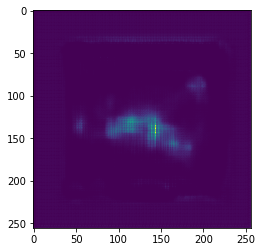

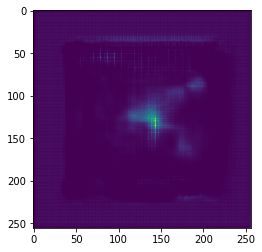

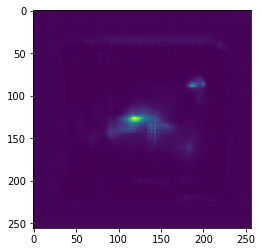

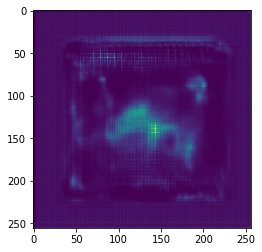

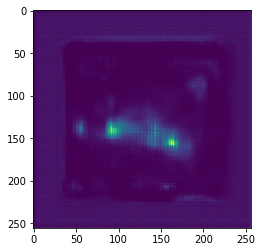

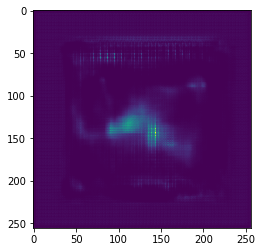

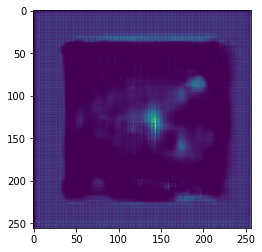

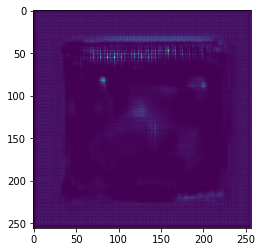

In [43]:
from models.utils import _sigmoid
for i in range(20):
    plt.imshow(_sigmoid(hm[0][i].cpu().detach()))
    plt.show()

In [19]:
count=[]
for index,batch in enumerate(loader):
    count.append(dict(batch_size=len(batch['input']),res=batch['res'],pic_size=batch['input'].shape[2]))
    print(index,len(batch['wh']),batch['res'],batch['input'].shape[2])


0 16 256 512
1 16 256 512
2 8 128 512
3 32 256 384
4 64 64 192
5 32 256 384
6 16 32 192
7 16 32 192
8 16 256 512
9 32 256 384
10 8 128 512
11 8 32 256
12 48 32 128
13 32 256 384
14 16 32 192
15 8 32 256
16 32 256 384
17 32 256 384
18 64 128 256
19 48 32 128
20 64 64 192
21 64 128 256
22 32 128 384
23 16 32 192
24 16 256 512


KeyboardInterrupt: 

In [16]:
count_pic=dict(pic_64=0,pic_128=0,pic_192=0,pic_256=0,pic_384=0,pic_512=0)


In [17]:
for cou in count:
    count_pic['pic_'+str(cou['pic_size'])]+=cou['batch_size']

In [22]:
count_res=dict(res_64=0,res_128=0,res_32=0,res_256=0)
for cou in count:
    count_res['res_'+str(cou['res'])]+=cou['batch_size']

In [23]:
print(count_res)

{'res_64': 17888, 'res_128': 9984, 'res_32': 16489, 'res_256': 7056}


In [18]:
print(count_pic)

{'pic_64': 10752, 'pic_128': 13824, 'pic_192': 5904, 'pic_256': 9113, 'pic_384': 8320, 'pic_512': 3504}


In [45]:
count_pic={'pic_64': 10752, 'pic_128': 13824, 'pic_192': 5904, 'pic_256': 9113, 'pic_384': 8320, 'pic_512': 3504}

In [54]:
sum_pic=0
sum_pic_num=0
for k,v in count_pic.items():
    
    sum_pic_num+=v
    res_for_count=int(k[4:])
    if res_for_count==64:
        res_for_count=128
    sum_pic+=(res_for_count**2)*v
    print((int(k[4:])**2)*v)
    print(k[4:])
    print(v)

44040192
64
10752
226492416
128
13824
217645056
192
5904
597229568
256
9113
1226833920
384
8320
918552576
512
3504


In [55]:
print(sum_pic,sum_pic_num)

3362914304 51417


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss, self).__init__()
#         self.loss_func=torch.nn.MSELoss(reduction='none')
        self.neg_loss = self._neg_loss
    def forward(self,output,hm):   
        output=self.sigmoid(output)
        loss=self.neg_loss(output,hm)
        return loss
    def sigmoid(self,x):
        y = torch.clamp(x.sigmoid_(), min=1e-4, max=1-1e-4)
        return y
    def _neg_loss(self,pred, gt):
        pos_inds = gt.eq(1).float()
        neg_inds = gt.lt(1).float()

        neg_weights = torch.pow(1 - gt, 4)

        loss = 0

        pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
        neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

        num_pos  = pos_inds.float().sum()
        pos_loss = pos_loss.sum()
        neg_loss = neg_loss.sum()

        if num_pos == 0:
            loss = loss - neg_loss
        else:
            loss = loss - (pos_loss + neg_loss) / num_pos
        return loss
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
acc_log=AverageMeter()
loss_log=AverageMeter()
import math
from tqdm import tqdm
cuda_device=1
model=resnet_mr(num_classes=20)
model.cuda(cuda_device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 80,100], gamma=0.5)
# params=torch.load('params.pth')
# model.load_state_dict(params)
end=time.time()
loss_func=FocalLoss()

mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
def draw_pic_hm(data,batch_heatmap):
    classes=["aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
"horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
"train", "tvmonitor"]
    for pic,heatmap in zip(data,batch_heatmap):
        plt.imshow(pic.permute(1,2,0)*std+mean)
        plt.show()
        plt.figure(figsize=[20,20])
        for index,hm in enumerate(heatmap):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(hm)
        plt.show()
def adjust_learning_rate(optimizer, batch_size,epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = 0.01*(batch_size/256)*((0.5)**(epoch//20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
for e in range(0,100):
    loss_log.reset()
    scheduler.step()
    loader=tqdm(loader)
    for index,((data,hm),l) in enumerate(loader):
#         print(data.shape,hm.shape)
        num=int(math.log(l//32,2))+1
        batch_size=len(data)
        data=data.cuda(cuda_device,non_blocking=True)
        hm=hm.cuda(cuda_device,non_blocking=True)
#         bg=bg.cuda(cuda_device)
#         clsid=clsid.cuda(cuda_device)
        output=model(data,num,True)
#         draw_pic_hm(data.cpu(),hm.cpu())
    #         print(output.shape,l)
        loss=loss_func(output,hm)
#         print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        adjust_learning_rate(optimizer,batch_size,e)
        optimizer.step()
        loss_log.update(loss.item())
        loader.set_description('loss:%.3f(%.3f) time:%.3f epoch%d/%d'%(loss_log.val,loss_log.avg,time.time()-end,e,100))
        end=time.time()
    print('epoch:%d loss:%.3f'%(e,loss_log.avg))

  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:0 loss:6.042


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:1 loss:3.492


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:2 loss:3.314


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:3 loss:3.140


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:4 loss:3.026


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:5 loss:3.044


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:6 loss:2.964


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:7 loss:2.937


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:8 loss:2.825


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:9 loss:2.785


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:10 loss:2.711


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:11 loss:2.677


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:12 loss:2.627


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:13 loss:2.578


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:14 loss:2.559


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:15 loss:2.490


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:16 loss:2.434


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:17 loss:2.365


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:18 loss:2.352


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:19 loss:2.318


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:20 loss:2.217


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:21 loss:2.152


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:22 loss:2.135


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:23 loss:2.021


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:24 loss:2.054


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:25 loss:1.982


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:26 loss:1.948


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:27 loss:1.899


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:28 loss:1.851


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:29 loss:1.768


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:30 loss:1.881


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:31 loss:1.798


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:32 loss:1.810


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:33 loss:1.681


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:34 loss:1.635


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:35 loss:1.554


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:36 loss:1.614


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:37 loss:1.514


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:38 loss:1.421


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:39 loss:1.419


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:40 loss:1.223


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:41 loss:1.118


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:42 loss:1.109


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:43 loss:1.050


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:44 loss:1.039


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:45 loss:0.994


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:46 loss:0.968


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:47 loss:1.001


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:48 loss:0.934


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:49 loss:0.902


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:50 loss:0.916


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:51 loss:0.851


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:52 loss:0.862


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:53 loss:0.801


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:54 loss:0.803


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:55 loss:0.768


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:56 loss:0.803


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:57 loss:0.766


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:58 loss:0.732


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:59 loss:0.734


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:60 loss:0.648


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:61 loss:0.607


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:62 loss:0.626


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:63 loss:0.560


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:64 loss:0.556


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:65 loss:0.542


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:66 loss:0.529


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:67 loss:0.536


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:68 loss:0.514


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:69 loss:0.534


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:70 loss:0.490


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:71 loss:0.468


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:72 loss:0.461


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:73 loss:0.465


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:74 loss:0.454


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:75 loss:0.464


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:76 loss:0.458


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:77 loss:0.457


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:78 loss:0.437


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:79 loss:0.426


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:80 loss:0.400


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:81 loss:0.409


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:82 loss:0.392


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:83 loss:0.360


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:84 loss:0.355


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:85 loss:0.382


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:86 loss:0.392


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:87 loss:0.374


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:88 loss:0.351


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:89 loss:0.371


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:90 loss:0.371


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:91 loss:0.351


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:92 loss:0.381


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:93 loss:0.344


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:94 loss:0.324


  0%|          | 0/1193 [00:00<?, ?it/s]

epoch:95 loss:0.336


loss:0.288(0.338) time:1.468 epoch96/100:  60%|██████    | 717/1193 [15:56<10:44,  1.35s/it]

In [ ]:
print('loss%d'%(4.5))
print(loss_log.avg)
input('s')
torch.save(model.state_dict(),'params_focal_lossss.pth')

In [ ]:
import math
from tqdm import tqdm
cuda_device=1
end=time.time()
loss_func=FocalLoss()
loader=tqdm(loader)
model.eval()
classes=["aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
"horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
"train", "tvmonitor"]
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
def draw_pic_hm(data,batch_heatmap,hms):
    classes=["aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
"horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
"train", "tvmonitor"]
#     data=data.numpy()[...,::-1]
    for pic,heatmap,labels_hm in zip(data,batch_heatmap,hms):
        plt.imshow(((pic.permute((1,2,0))*std+mean)*255).int())
        plt.show()
#         plt.figure(figsize=[20,20])
        plt.subplot(1,2,1)
        for index,(out_hm) in enumerate(heatmap):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(out_hm)
        plt.show()
        plt.subplot(1,2,2)
        for index,(label_hm) in enumerate(labels_hm):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(label_hm)
        plt.show()
with torch.no_grad():
    loss_log.reset()
    for index,((data,hm),l) in enumerate(loader):
        num=int(math.log(l//32,2))+1
        data=data.cuda(cuda_device)
        hm=hm.cuda(cuda_device)
        output=model(data,num,False)
        draw_pic_hm(data.cpu(),loss_func.sigmoid(output.cpu()),hm.cpu())
        input('s')
        loss=loss_func(output,hm)
        loss_log.update(loss.item())        
        loader.set_description('loss:%.3f(%.3f) time:%.3f batch%d/%d'%(loss_log.val,loss_log.avg,time.time()-end,index,len(loader)))
        input('s')

In [ ]:
torch.save(model.state_dict(),'params_9.pth')

In [ ]:
print('epoch:%d loss:%.3f'%(e,loss_log.avg))

In [ ]:
a=torch.tensor(range(20))
a=a.view(4,5)

In [ ]:
a.float().sigmoid()

In [ ]:
begin loss=0.5

In [ ]:
for index,(i,j,k,z) in enumerate(loader):
    print(i.shape,j.shape,k.shape,z)
    a=input('s')
    pass
#     print(index,i.shape,j.shape)

In [ ]:
a=[1,2,3,4]
b=a.copy()
b[1]=4
print(a,b)

In [ ]:
count_8=0
count_16=0
count_32=0
count_64=0
count_128=0
count_256=0
count_513=0
count_40=0
count_80=0
count_160=0
count_pics=0
count_objs=0
count_40_64=0
count_40_128=0
count_40_160=0
count_40_256=0
count_40_max=0
count_80_128=0
count_80_160=0
count_80_256=0
count_80_max=0
count_160_256=0
count_160_384=0
count_160_512=0
count_160_max=0
for i in a:
    count_pics+=1
    whs=i['wh']
    reg=i['reg_mask']
    for x in reg:
        if x==1:
            count_objs+=1
    for w,h in whs:
        w,h=w*4,h*4
        if w==0 and h==0:
            break
        if min(w,h)<=40:
            count_40+=1
            if max(w,h)<=64:
                count_40_64+=1
            elif max(w,h)<=128:
                count_40_128+=1
            elif max(w,h)<=160:
                count_40_160+=1
            elif max(w,h)<=256:
                count_40_256+=1
            else:
                count_40_max+=1
        elif min(w,h)<=80:
            count_80+=1
            if max(w,h)<=128:
                count_80_128+=1
            elif max(w,h)<=160:
                count_80_160+=1
            elif max(w,h)<=256:
                count_80_256+=1
            else:
                count_80_max+=1
        elif min(w,h)<=160:
            count_160+=1
            if max(w,h)<=256:
                count_160_256+=1
            elif max(w,h)<=384:
                count_160_384+=1
            elif max(w,h)<=512:
                count_160_512+=1
            else:
                count_160_max+=1
        else:
            count_513+=1
# print(count_small,count_middle,count_large)

In [ ]:
print(count_40,count_80,count_160,count_513)
print(count_40_64,count_40_128,count_40_160,count_40_256,count_40_max)
print(count_80_128,count_80_160,count_80_256,count_80_max)
print(count_160_256,count_160_384,count_160_512,count_160_max)

In [ ]:
len(a)
plt.imshow((a[3]['input'].transpose(1,2,0)*a.std+a.mean)[...,::-1])
plt.show()

In [ ]:
def show(i):
    pics=a[i]['hm']
    input_pic=a[i]['input']
    plt.imshow((a[i]['input'].transpose(1,2,0)*a.std+a.mean)[...,::-1])
    plt.show()
    for pic in pics:
        if pic.sum()>0:
            plt.imshow(pic)
            plt.show()

In [ ]:
while True:
    b=input('s')
    show(int(b))

In [ ]:
for i in range(1,10):
    plt.imshow((a[i]['input'].transpose(1,2,0)*a.std+a.mean)[...,::-1])
    plt.show()
    b=input('s')

In [ ]:
a[0]['input'].shape

In [ ]:
# for k,v in a[0].items():
#     print(k)
# print(a[0]['bboxs'])
# print(a[0]['bboxs'])
# print(a[0]['wh'])
# print(a[0]['hm'])
for pic in a[0]['hm']['hm_32']:
    print('hm_32')
    if pic.sum()>0:
        plt.imshow(pic)
        plt.show()
for pic in a[0]['hm']['hm_64']:
    print('hm_64')
    if pic.sum()>0:
        plt.imshow(pic)
        plt.show()
for pic in a[0]['hm']['hm_128']:
    print('hm_128')
    if pic.sum()>0:
        plt.imshow(pic)
        plt.show()
for pic in a[0]['hm']['hm_256']:
    print('hm_256')
    if pic.sum()>0:
        plt.imshow(pic)
        plt.show()
plt.imshow((a[0]['input'].transpose(1,2,0)*a.std+a.mean)[...,::-1])
plt.show()

In [ ]:
objs_32=dict(pics_64=[],pics_128=[],pics_192=[],pics_256=[],pics_384=[],pics_512=[])
objs_64=dict(pics_128=[],pics_192=[],pics_256=[],pics_384=[],pics_512=[])
objs_128=dict(pics_256=[],pics_384=[],pics_512=[])
objs_256=dict(pics_384=[],pics_512=[])
count_40=0
count_80=0
count_160=0
count_256=0
for index,j in enumerate(a):
    for obj_index,(w,h) in enumerate(j['wh']):
        w,h=w*4,h*4
        if w==0 and h==0:
            break
        if min(w,h)<=40:
            count_40+=1
            if max(w,h)<=64:
                objs_32['pics_64'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=128:
                objs_32['pics_128'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=192:
                objs_32['pics_192'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=256:
                objs_32['pics_256'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=384:
                objs_32['pics_384'].append(dict(pic_index=index,obj_index=obj_index))
            else:
                objs_32['pics_512'].append(dict(pic_index=index,obj_index=obj_index))
        elif min(w,h)<=80:
            count_80+=1
            if max(w,h)<=128:
                objs_64['pics_128'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=192:
                objs_64['pics_192'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=256:
                objs_64['pics_256'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=384:
                objs_64['pics_384'].append(dict(pic_index=index,obj_index=obj_index))
            else:
                objs_64['pics_512'].append(dict(pic_index=index,obj_index=obj_index))
        elif min(w,h)<=160:
            count_160+=1
            if max(w,h)<=256:
                objs_128['pics_256'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=384:
                objs_128['pics_384'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=512:
                objs_128['pics_512'].append(dict(pic_index=index,obj_index=obj_index))
        else:
            count_256+=1
            if max(w,h)<=384:
                objs_256['pics_384'].append(dict(pic_index=index,obj_index=obj_index))
            elif max(w,h)<=512:
                objs_256['pics_512'].append(dict(pic_index=index,obj_index=obj_index))

In [ ]:
import torch
torch.save(objs,'./objs_2')

In [ ]:
def get(num):
    wh=a[objs_32['pics_64'][num]['pic_index']]['wh'][objs_32['pics_64'][num]['obj_index']]*4
    return wh

In [ ]:
i=0 
while True:
    i+=1 
    show(i)

In [ ]:
def show(num):
    pic,wh,bbox,obj_pic,crop_pic,bbox_crop,hm,bg=dataset[num]
    print(obj_pic.shape,bbox_crop,bbox,wh)
    plt.subplot(1,5,1)
    plt.imshow((obj_pic.transpose(1,2,0)*a.std+a.mean)[...,::-1])
    plt.subplot(1,5,2)
    plt.imshow((pic.transpose(1,2,0)*a.std+a.mean)[...,::-1])
    plt.subplot(1,5,3)
    plt.imshow((crop_pic.transpose(1,2,0)*a.std+a.mean)[...,::-1])
    plt.subplot(1,5,4)
    plt.imshow(hm.squeeze(0))
    plt.subplot(1,5,5)
    plt.imshow(bg.squeeze(0))
    plt.show()

In [ ]:
DataLoader(dataset, batch_size=args.batch_size_test, shuffle=False, num_workers=args.workers)

In [ ]:
b=a[0]['meta']
bboxs=b['gt_det']
pics1=a[0]['hm'][0]
for bbox in bboxs:
    pics1[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2]),]=1
plt.imshow(pics1)
plt.show()

In [2]:
import os
import math
import torch
import torch.nn as nn
import torchvision.models

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        if stride != 1:
            self.conv1 = nn.Conv2d(inplanes,
                                   planes,
                                   kernel_size=4,
                                   stride=stride,
                                   padding=1,
                                   bias=False)
        else:
            self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out


class ResNetMR(nn.Module):
    def __init__(self, block, layers, num_classes=21):
        super(ResNetMR, self).__init__()
        self.inplanes = 32
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1)
        self.layer1_4=self._make_layer(block,128,layers[0], stride=1)
        self.inplanes=32
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer2_4 = self._make_layer(block, 128, layers[1], stride=1)
        self.inplanes = 64
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer3_4 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)
        self.layer5 = self._make_layer(block, 512, layers[4], stride=2)
        self.layer6 = self._make_layer(block, 1024, layers[5], stride=2)
        self.layer4_tr=nn.Sequential(nn.Conv2d(256,
                                               512,
                                               kernel_size=4,
                                               stride=2,
                                               padding=1,
                                               bias=False),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True))
        self.layer6_tr=nn.Sequential(nn.ConvTranspose2d(1024,
                                                        512,
                                                        kernel_size=4,
                                                        stride=2,
                                                        padding=1,
                                                        bias=False),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True))
        self.inplanes=1536
        self.layer_f=self._make_layer(block,768,2,stride=1)
        self.final_cls=nn.Conv2d(768,num_classes,1,1)
    def fusion(self,input_middle):
        output_4=self.layer4(input_middle)
        output_5=self.layer5(output_4)
        output_6=self.layer6(output_5)
        output_4=self.layer4_tr(output_4)
        output_6=self.layer6_tr(output_6)
        output=torch.cat([output_4,output_5,output_6],1)
        output=self.layer_f(output)
        output=self.final_cls(output)
        return output
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if stride != 1:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes,
                              planes * block.expansion,
                              kernel_size=4,
                              stride=stride,
                              padding=1,
                              bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )
            else:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes,
                              planes * block.expansion,
                              kernel_size=1,
                              stride=stride,
                              bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x,pattern,cal):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x1 = self.layer1(x)
        self.x1=x1
        if pattern==1:
            x4=self.layer1_4(x1)
            fm=self.fusion(x4)
            return fm
        
        self.x2=self.layer2(self.x1)
        if pattern==2:

            x4=self.layer2_4(self.x2)
            fm=self.fusion(x4)
            return fm
        
        self.x3=self.layer3(self.x2)
        if pattern==3:
            fm=self.fusion(self.x3)
            return fm
        if pattern==4:
            self.x4=self.layer3_4(self.x3)
            fm=self.fusion(self.x4)
            return fm

def resnet_mr(pretrained=False,**kwargs):
    model=ResNetMR(BasicBlock,[1,1,2,2,2,2,2],**kwargs)    
    return model